## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import copy

from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra
from src.postprocessing import review
from src import utils

# Correct sequence fall off detection
We have a property in the program that lets us pass in a "truth" set. This truth set we will pull from Delong lab and will primarily be used for debugging our hybrids. The steps we need to take:
1. Load in SpectrumMill results and create a "truth" set where each entry in this json file has the form:
```json
{
    spectrum_id: {
        "sequence": str, 
        "hybrid": bool, 
        "parent": str
    }
}
```
2. Run hyped search with the "truth_set" param set to the file generated in step 1
3. Load in the file created (output_dir + 'fall_off.json')
4. Run all analysis

## Constants

In [2]:
spec_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredSpec/'
db_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredNOD2.fasta'
output_dir = '/Users/zacharymcgrath/Desktop/Experiment output/fall_off/'
specmil_truth_set = '/Users/zacharymcgrath/Downloads/NOD2_E3_results.ssv'

minPep = 3
maxPep = 30
tolerance = 20
relative_abundance_filter = 0.0
precursor_tolerance = 10
peak_filter = 25
verbose = True


## 1. Load in SpectrumMill and create truth file

In [3]:
# first load in the results
specmil_results = pd.read_csv(specmil_truth_set, sep=';')
specmil_results.head(5)


,number,filename,parent_charge,score,deltaForwardReverseScore,deltaRank1Rank2Score,percent_scored_peak_intensity,totalIntensity,previous_aa,sequence,next_aa,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,species,entry_name
0,1,NOD2_E3.13446.13477.2,2,10.10,10.10,9.91,84.5,183000.0,(E),DPQVEQLEL,(-),48.35,26.0,535.7725,MOUSE,ins1C18
1,2,NOD2_E3.18005.18246.2,2,12.84,11.07,12.84,97.8,40000000.0,(G),DLQTLALEVA,(-),65.78,29.0,536.8007,MOUSE,ins1C3
2,3,NOD2_E3.13729.13828.2,2,12.43,6.68,7.86,90.7,2200000.0,(G),DLQTLALE,(-),49.52,22.0,451.7460,MOUSE,ins1C5
3,4,NOD2_E3.15226.15503.2,2,11.17,6.21,6.67,89.1,1740000.0,(G),DLQTLAL,(-),54.38,169.0,387.2243,MOUSE,ins1C6
4,5,NOD2_E3.21510.21510.2,2,12.54,12.54,12.54,91.3,91900.0,(G),DLQTLALLL,(D),76.92,3.0,500.3081,MOUSE,HYBRID: mouse ins1C PQVEQLELGGSPGDLQTLAL-LLDEG...


In [4]:
def get_hybrid_seq(peptide: str, protein: str) -> str:
    '''
    From a hybrid protein that looks like 
    ABCDE-FGHI
    
    and a peptide that looks like
    DEFGH
    
    extract 
    DE-FGH
    
    Inputs:
        peptide: (str) the desired subseq
        protein: (str) the full string with the hybrid character 
    Outputs:
        new peptide string
    '''
    # copy the protein
    prot_cp = copy.deepcopy(protein)
    
    # find the subseq
    peptide_idx = protein.replace('-', '').replace('(', '').replace(')', '').index(peptide)
    
    # get that stretch of prot
    add_on = len(peptide) + (1 if '-' in protein else 2)
    
    return protein[peptide_idx:peptide_idx+add_on]

In [5]:
# json to store results in
json_truth_set = {}

# go through every entry in the database, find out if its a hybrid and get the sequence, ided by the filename
for idx, row in specmil_results.iterrows():
    
    # all the ids seem to have .pkl at the end of them so add that
    key = row['filename'] + '.pkl'
    hybrid = 'HYBRID' in row['entry_name']
    
    seq = row['sequence'] if not hybrid else get_hybrid_seq(row['sequence'], row['entry_name'])
    
    json_truth_set[key] = {
        'hybrid': hybrid, 
        'sequence': seq, 
        'parent': row['entry_name']
    }
    
full_truth_path = output_dir + 'specmil_truth_set.json'
    
json.dump(json_truth_set, open(full_truth_path, 'w'))

## 2. Run hypedsearch with the truth set

In [6]:
truth_run_params = {
    'spectra_folder': spec_file,
    'database_file': db_file,
    'output_dir': output_dir,
    'min_peptide_len': minPep,
    'max_peptide_len': maxPep,
    'tolerance': tolerance,
    'precursor_tolerance': precursor_tolerance,
    'peak_filter': peak_filter, 
    'relative_abundance_filter': relative_abundance_filter,
    'digest': 'trypsin', 
    'missed_cleavages': 2,
    'verbose': verbose,
    'DEBUG': False,
    'cores': 16,
    'truth_set': full_truth_path
}

runner.run(truth_run_params)


DEV set to True. 
Tracking when correct answer falls off. 
Results are stored in a json named 'fall_off.json' in the specified output directory
File will be of the form

    {
        spectrum_id: {
            hybrid: bool, 
            truth_sequence: str, 
            fall_off_operation: str, 
        }
    }
            
Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 280/280 [100%]
Sorting the set of protein masses...
Done
Initializing other processors...
Done.
Creating an alignment for 641/1086 [59%]ope
Creating an alignment for 730/1086 [67%]ope
Creating an alignment for 1085/1086 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/Experiment output/fall_off/...
Could not make an alignment for 245/1086 spectra (22%)


## 3. Load in the fall off results

In [6]:
fall_off_results = json.load(open(output_dir + 'fall_off.json'))
len(fall_off_results)

245

## 4. Run all analysis
### Plot the raw results

In [7]:
# first load them into dictionaries by {type: [seq]}
typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    typed_fall_off[entry['fall_off_operation']].append((_id, entry))
    

<BarContainer object of 5 artists>

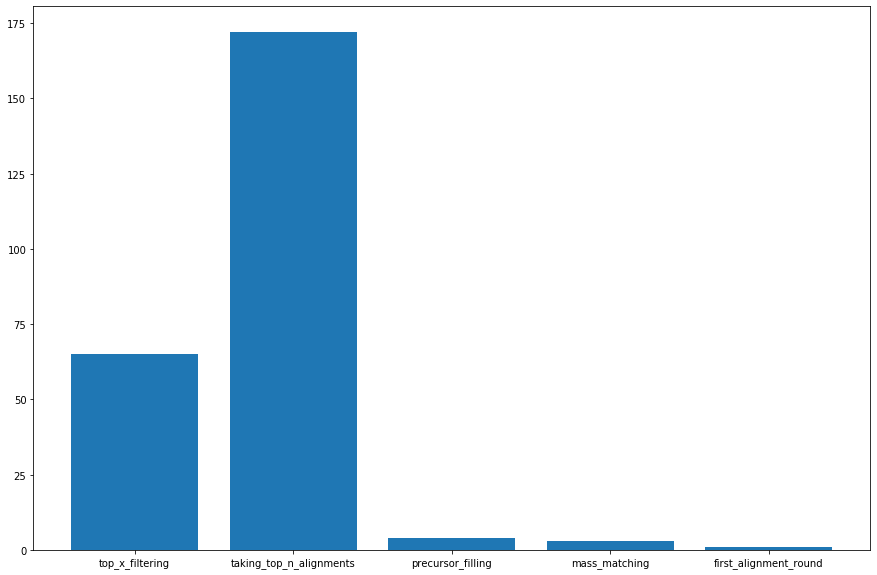

In [8]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)


### Just hybrid results

In [9]:
hybrid_typed_fall_off = defaultdict(list)
nonhybrid_typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    
    if entry['hybrid']:
        hybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))
        
    else:
        nonhybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))

Text(0.5, 1.0, 'Hybrid fall off positions')

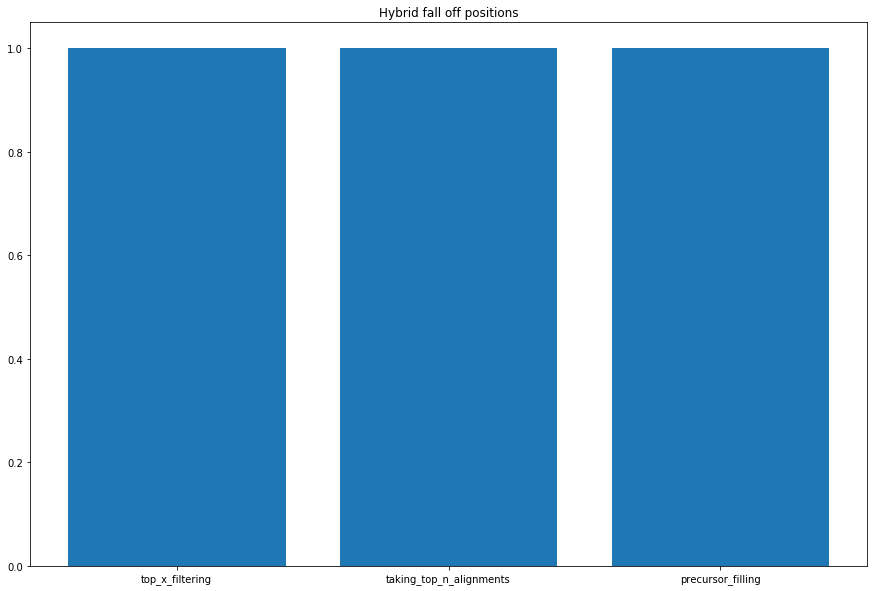

In [10]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(hybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Hybrid fall off positions')

Text(0.5, 1.0, 'Non hybrid fall off positions')

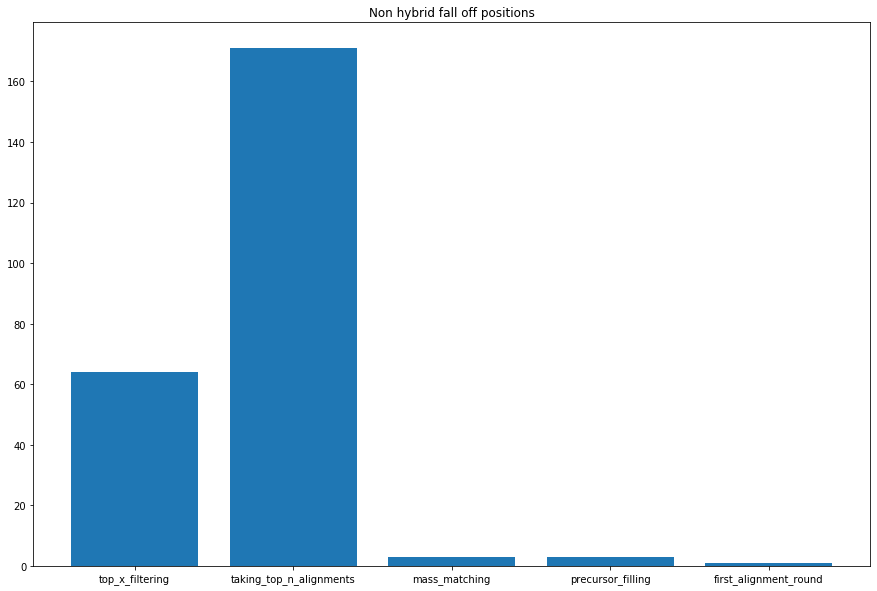

In [11]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(nonhybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Non hybrid fall off positions')

### Hybrid analysis

In [12]:
precursor_fall_offs = [x for x in hybrid_typed_fall_off['precursor_filling']]

In [13]:
for pfo in precursor_fall_offs:
    t_seq = pfo[1]['truth_sequence']
        
    print(f'Truth sequence: {t_seq}')
    print('Before\n===========================================')
    for x in pfo[1]['meta_data']['sequences_before_precursor_filling']:
        if x[0][:2] == t_seq[:2] and x[0][-2:] == t_seq[-2:]:
            print(x)
            
    print('After\n===========================================')
    for x in pfo[1]['meta_data']['sequences_after_precursor_filling']:
        if x[0][:1] == t_seq[:1] and x[0][-1:] == t_seq[-1:]:
            print(x)
            
    print()

Truth sequence: DLQTL-EVE
Before
['DLQTLAEPEEVE', 'DLQT(L)AEPEEVE']
['DLQTLFRNTNVE', 'DLQTL-FRNTNVE']
['DLQTLHTLDVE', 'DLQTL-HTLDVE']
['DLQTLPNVE', 'DLQTL-PNVE']
['DLQTLNPVE', 'DLQTL-NPVE']
['DLQTLGAPVE', 'DLQTL-GAPVE']
['DLQTLPQVE', 'DLQTL-PQVE']
['DLQTLINPVE', 'DLQTL-INPVE']
After



In [14]:
top_x_filtering = [x for x in hybrid_typed_fall_off['top_x_filtering']]

In [15]:
def is_close(truth, tried, ion, close_dist=2):
    if len(tried) > len(truth):
        return False
    
    if ion == 'b':
        return truth[:close_dist].replace('I', 'B').replace('L', 'B') == tried[:close_dist].replace('I', 'B').replace('L', 'B')
    else:
        return truth[-close_dist:].replace('I', 'B').replace('L', 'B') == tried[-close_dist:].replace('I', 'B').replace('L', 'B')
    
for _id, txf in top_x_filtering:
    t_seq = txf['truth_sequence']
    
    print(f'Truth sequence: {t_seq}')
    
    print('Kept b hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)

    print('Kept y hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print('Lost b hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)
            
    print('Lost y hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print()

Truth sequence: DLQTLAL-NAAR
Kept b hits close to correct half
DLQT
DLQDQL
Kept y hits close to correct half
Lost b hits close to correct half
DIQ
DLQ
DLQL
DLQI
DIQI
DLQNL
DIQVK
DIQVKE
Lost y hits close to correct half
ESKKAARAAR
NAAR
AARAAR
RAALAAR
EGPRCEVAAR
LCLALAWAAR



### Non hybrid analysis
#### Precursor filling

In [16]:
# get the precursor filling subjects
nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['precursor_filling']]

In [17]:
# go through every entry and find the sequences that were closest to the real sequence as possible
# closeness is: 
#   1. Having a lot of the right amino acids
#   2. Not have too many amino acids or too few
# Prioritize 1, rank by 2
def closeness(t_seq, trying, observed_precursor, observed_precursor_charge) -> (int, int):
    
    from_right = 0
    from_left = 0
    
    prec_distance = abs(gen_spectra.get_precursor(trying, observed_precursor_charge) - observed_precursor)
    
    # first check if they ARE the same
    if t_seq == trying:
        return (len(t_seq), 0, prec_distance)
    
    # go from left to right
    i = 0
    while i < len(t_seq) and i < len(trying) and t_seq[i] == trying[i]:
        i += 1
        from_left += 1
        
    # now right to left
    i = -1
    while abs(i) < len(t_seq) + 1 and abs(i) < len(trying) + 1 and t_seq[i] == trying[i]:
        i -= 1
        from_right += 1
        
    return (from_left + from_right, abs(len(t_seq) - len(trying)), prec_distance)

for _id, nhpfo in nh_precursor_fall_off:
    
    # get the real sequence
    t_seq = nhpfo['truth_sequence']
    
    # keep track of the best of the close ones 
    overlapped_idxed_close_hits = defaultdict(list)
    
    observed_prec = nhpfo['meta_data']['observed_precursor_mass']
    observed_prec_charge = nhpfo['meta_data']['observed_percursor_charge']
    
    for non_hyb, hyb in nhpfo['meta_data']['sequences_before_precursor_filling']:
        overlap, dist, prec_dist = closeness(t_seq, non_hyb, observed_prec, observed_prec_charge)
        overlapped_idxed_close_hits[overlap].append((non_hyb, hyb, dist, prec_dist))
        
    # now get the hightest key
    best_key = max(list(overlapped_idxed_close_hits.keys()))
    
    # show the best results sorted by their distance
    print(f'({_id}) Hits with the most overlap ({best_key} AAs) for sequence {t_seq} with allowed gap {nhpfo["meta_data"]["allowed_gap"]}')
    print('=====================================================================================')
    for seq, hyb_seq, dist, prec_distance in sorted(overlapped_idxed_close_hits[best_key], key=lambda x: x[2]):
        print(f'{seq} \t {dist} \t {prec_distance} \t {hyb_seq}')
        
    print()
    

(NOD2_E3.3698.3698.4.pkl) Hits with the most overlap (19 AAs) for sequence DYNMAKAKMKNKQLPSAGA with allowed gap 7
KGQKYFDSGDYNMAKAKMKNKQLPSAGA 	 9 	 252.62053107500014 	 None
QKGQKYFDSGDYNMAKAKMKNKQLPSAGA 	 10 	 284.63517557500006 	 None

(NOD2_E3.11929.11929.3.pkl) Hits with the most overlap (17 AAs) for sequence PDIPKGRFSESVELWRG with allowed gap 7
PDIPKGRFSESVELWRGQ 	 1 	 42.67931763333331 	 None

(NOD2_E3.6083.6083.2.pkl) Hits with the most overlap (12 AAs) for sequence DPLNPIKQ with allowed gap 4
DPLNDPLNPIKQ 	 4 	 219.5981902499999 	 DPLN-DPLNPIKQ



#### Taking the top n alignments

In [18]:
top_n = nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['taking_top_n_alignments']]

In [22]:
cleaner = lambda s: s.replace('-', '').replace('(', '').replace(')', '')

# ed_len_5 = []
# ed_len_10 = []
# ed_len_20 = []
# ed_len_all = []

cs_len_5 = []
cs_len_10 = []
cs_len_20 = []
cs_len_all = []

for _id, top_n_spec in top_n:
    t_seq = top_n_spec['truth_sequence']
    
    print(f'Top n alignments for sequence {t_seq}')
    print('============================================================')
    print('sequence \t b score \t y score \t total score \t precursor distance \t hybrid')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]} \t {"hybrid_sequence" in x}') for x in top_n_spec['meta_data']['top_n']]
    
    print('------------------------------------------------------------')
    print('Missed alignments for this sequence')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]} \t {"hybrid_sequence" in x}') for x in top_n_spec['meta_data']['not_top_n'][:10]]
    print('------------------------------------------------------------')
    all_alignments = [x for x in top_n_spec['meta_data']['top_n']] + [x for x in top_n_spec['meta_data']['not_top_n']]
    num_hyb = len([0 for x in all_alignments if 'hybrid_sequence' in x])
    p_hyb = int(100 * (float(num_hyb) / float(len(all_alignments))))
    scores = [x['total_score'] for x in all_alignments]
    avg_score = np.mean(scores)
    min_score = min(scores)
    
#     # get the average edit distance for top 5, 10, 20 results
#     ed5 = []
#     ed10 = []
#     ed20 = []
#     ed_all = []
    
    t_seq_clean = cleaner(t_seq)

    # get the avg cosine distnace for top 5, 10, 20, all
    cs5 = []
    cs10 = []
    cs20 = []
    cs_all = []
    
    found_in = 0
    
    t_seq_sparse = utils.make_sparse_array(gen_spectra.gen_spectrum(t_seq)['spectrum'], .001, 1)
    
    for i, a in enumerate(top_n_spec['meta_data']['top_n'] + top_n_spec['meta_data']['not_top_n']):
        
        seq_sparse = utils.make_sparse_array(gen_spectra.gen_spectrum(a['sequence'])['spectrum'], .001, 1)
            
#         ed = (t_seq_clean, a['sequence'], 2)
        cs = utils.cosine_similarity(t_seq_sparse, seq_sparse)
            
        if i < 5:
#             ed5.append(ed)
            cs5.append(cs)
            
        if i < 10: 
#             ed10.append(ed)
            cs10.append(cs)
        
        if i < 20:
#             ed20.append(ed)
            cs20.append(cs)
    
#         ed_all.append(ed)
        cs_all.append(cs)
    
        if a['sequence'] == t_seq_clean:
            found_in = i
            break
    
    avg5 = np.mean(cs5)
    avg10 = np.mean(cs10)
    avg20 = np.mean(cs20)
    avg_all = np.mean(cs_all)
    
    which = None
    
    if found_in < 5:
        cs_len_5.append((avg5, len(t_seq)))
        which = avg5
        
    elif found_in < 10:
        cs_len_10.append((avg10, len(t_seq)))
        which = avg10
        
    elif found_in < 20:
        cs_len_20.append((avg20, len(t_seq)))
        which = avg20
        
    else:
        cs_len_all.append((avg_all, len(t_seq)))
        which = avg_all
    
    print(f'Stats: \t Number alignments: {len(all_alignments)} \t % hybrid: {p_hyb} \t Average score: {avg_score} \t min score: {min_score}')
    print(f'Average cosine similarity with correct sequence found in {found_in}: {which}')
    print()

Top n alignments for sequence DTGAGSIREAGGAFGKREKAEE
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
SEESYQKYKFMELNLAQK 	 3 	 3 	 6 	 0.0018110600001364219 	 False
SSLEKSYELPEATGLSPLSVE 	 3 	 3 	 6 	 0.0037213399998563546 	 False
SGPQNKFELSMFNIRKPNE 	 3 	 2 	 5 	 0.0026855400000158625 	 False
SSLDSGVPKRFSGSLIGGNASAE 	 3 	 2 	 5 	 0.0031859399999802918 	 False
SYDIVLVKEESAEVPEAASAE 	 3 	 2 	 5 	 0.003555660000017724 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
SLVSNYLQTQEREGILQEE 	 3 	 3 	 5.0 	 0.0009379400000284477 	 True
SLVSNYLQTQEGEAKSPGEAK 	 3 	 3 	 5.0 	 0.0009379400000284477 	 True
SYGDLGGPIITTDAATAVEQEK 	 3 	 3 	 4.5 	 0.0013082599999734157 	 True
STCFRPACVKLGREGILQEE 	 3 	 3 	 4.5 	 0.0033603399999151407 	 True
DTGAGSIREAGGAFGKREKAEE 	 1 	 3 	 4 	 0.0018438600000649785 	 Fa

Stats: 	 Number alignments: 35 	 % hybrid: 65 	 Average score: 3.942857142857143 	 min score: 0
Average cosine similarity with correct sequence found in 8: 0.22952629354737386

Top n alignments for sequence DFPEFLTMMARKMKDTDSEEEIR
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
YASSMWTISINSAINDDPVDYEATR 	 3 	 3 	 6 	 0.008482033333393701 	 False
SCPIIVHCSDGAGRSGATSSSRSELEGR 	 2 	 4 	 5.5 	 0.0025399666667453857 	 True
KWTEGGGHSGSAQNSGCLTRSASANISR 	 3 	 2 	 5 	 0.00516096666683552 	 False
KEEESLHSGSAQNSGCLTRSASANISR 	 3 	 2 	 5 	 0.00845896666680801 	 False
PKGDDKDPSGSAQNSGCLTRSASANISR 	 3 	 2 	 5 	 0.008459300000026815 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
EIPGGQEAASGSAQNSGCLTRSASANISR 	 3 	 2 	 5 	 0.008459633333359307 	 False
SCPIIVHCSGSAQNSGCLTRSASANISR 	 3 	 2 	 5 	 0.008

Stats: 	 Number alignments: 66 	 % hybrid: 84 	 Average score: 2.871212121212121 	 min score: 0
Average cosine similarity with correct sequence found in 7: 0.1530039140644486

Top n alignments for sequence DHVTNLRKMGAPEAGMAEYLF
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
AKSPGEAKSPGEAKSPGEAEYLF 	 5 	 3 	 8 	 0.004982325000014498 	 False
GEAKSPGEAKSPAEAKSPGEYLF 	 5 	 2 	 7 	 0.004982325000128185 	 False
GEAKSPGEAKSPGEAKSPAEYLF 	 5 	 2 	 7 	 0.004982325000128185 	 False
GEAKSPAEAKSPGEAKSPGEYLF 	 4 	 3 	 7 	 0.004982325000128185 	 False
AEAKSPGEAKSPGEAKSPGEYLF 	 4 	 3 	 7 	 0.004982325000128185 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
DHVTNLRKMGAPEAGMAEYIF 	 4 	 2 	 6 	 0.0010881749999498425 	 False
DHVTNLRKMGAPEAGMAEYLF 	 4 	 2 	 6 	 0.0010881749999498425 	 False
EAEAARVEIKTLE

Stats: 	 Number alignments: 99 	 % hybrid: 86 	 Average score: 3.1464646464646466 	 min score: 0
Average cosine similarity with correct sequence found in 49: 0.047194099235764043

Top n alignments for sequence DQGRWWQQEEQLGPEESREEVRFP
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
DQGRWWQQEEQLSELDDRADALQAGA 	 6 	 6 	 12 	 0.004730174999735937 	 False
DQGRWWQQEEQLGDTALHAAAWKGYA 	 5 	 7 	 12 	 0.0028960750004216607 	 False
DQGRWWQQEEQLGRGGFTSDRGFQF 	 5 	 7 	 12 	 0.0033899250000786196 	 False
DQGRWWQQEEQLGLKITVNDSDQGAN 	 5 	 7 	 12 	 0.004366075000007186 	 False
DQGRWWQQEEQLGVATISANGDKDIGN 	 5 	 8 	 11.5 	 0.004366075000007186 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
DQGRWWQQEEQLFTQPNVELNQQN 	 5 	 6 	 11 	 0.0009161749998156665 	 False
DQGRWWQQEEQLGPEESREEVRFP 	 5 	 6 	 11 	 0.000

Stats: 	 Number alignments: 202 	 % hybrid: 93 	 Average score: 3.047029702970297 	 min score: 0
Average cosine similarity with correct sequence found in 56: 0.0806712441468525

Top n alignments for sequence DYPGLGKWNKKLLY
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KKDVPPSILRTPENT 	 3 	 2 	 5 	 0.0036815750000300795 	 False
KKAKETMKAQATKTM 	 3 	 1 	 4 	 8.532500004321264e-05 	 False
SSREEIKKSRVRGY 	 3 	 1 	 4 	 0.0001993250000396074 	 False
KKAKETMKAQQQLY 	 3 	 1 	 4 	 0.000759674999926574 	 False
KKAKETMKAQVAQAY 	 3 	 1 	 4 	 0.000759674999926574 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
KKAKETMKAQQLQY 	 3 	 1 	 4 	 0.0007596749999834174 	 False
KKAKETMKAQVVNGY 	 3 	 1 	 4 	 0.0007599249999543645 	 False
KKVSYSHIQSKARY 	 3 	 1 	 4 	 0.0012030750000349144 	 False
KKVSYSHIQSK

Stats: 	 Number alignments: 29 	 % hybrid: 62 	 Average score: 2.8448275862068964 	 min score: 0
Average cosine similarity with correct sequence found in 20: 0.11938425488536868

Top n alignments for sequence DALTEPPPEIEGEIKR
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
ADLTEPPPEIEGEIKR 	 4 	 5 	 9 	 0.00025603333335766365 	 False
EGITEPPPEIEGEIKR 	 4 	 5 	 9 	 0.00025603333335766365 	 False
DAITEPPPEIEGEIKR 	 4 	 5 	 9 	 0.00025603333335766365 	 False
EGLTEPPPEIEGEIKR 	 4 	 5 	 9 	 0.00025603333335766365 	 False
ADITEPPPEIEGEIKR 	 4 	 5 	 9 	 0.00025603333335766365 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
GEITEPPPEIEGEIKR 	 4 	 5 	 9 	 0.00025603333335766365 	 False
DALTEPPPEIEGEIKR 	 4 	 5 	 9 	 0.00025603333335766365 	 False
GELTEPPPEIEGEIKR 	 4 	 5 	 9 	 0.000256033333357

Stats: 	 Number alignments: 29 	 % hybrid: 55 	 Average score: 7.982758620689655 	 min score: 6
Average cosine similarity with correct sequence found in 20: 0.12406642189739621

Top n alignments for sequence DQELESLSAIEAELEKVAHQLQALR
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
SSLVSEPDGTIKRLIYATSSLDSGVPK 	 2 	 4 	 6 	 0.0056695749999562395 	 False
DQELESLSAIKRLIYATSSLDSGVPK 	 2 	 4 	 6 	 0.0056695749999562395 	 False
SSVVTEPDGTIKRLIYATSSLDSGVPK 	 2 	 4 	 6 	 0.005669824999927187 	 False
SSQNWPDGTIKRLIYATSSLDSGVPK 	 2 	 4 	 6 	 0.005900675000020783 	 False
NEEDVLDGTIKRLIYATSSLDSGVPK 	 2 	 4 	 5.5 	 0.0034266750000142565 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
DQELESLGTIKRLIYATSSLDSGVPK 	 2 	 4 	 5.5 	 0.005669824999927187 	 True
QDELESLSAIEAELEKVAHQLQALR 	 2 	 3 	 5 	 0.00061

Stats: 	 Number alignments: 95 	 % hybrid: 84 	 Average score: 4.3 	 min score: 0
Average cosine similarity with correct sequence found in 5: 0.2488860496077798

Top n alignments for sequence DSILNLLTSRSNAQRQ
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
SSDSLRTGRSILGGLAPE 	 8 	 3 	 11 	 0.004712700000141012 	 False
SDILNLLTSRSNAQRQ 	 5 	 6 	 11 	 0.0009683666665978308 	 False
SDLLNLLTSRSNAQRQ 	 5 	 6 	 11 	 0.0009683666665978308 	 False
SSPAARRYVTALGGLAPE 	 7 	 3 	 10 	 0.0003702999997585721 	 False
DSILNLIEQVEKQTSV 	 4 	 6 	 10 	 7.303333313757321e-05 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
DSILNLISNASDALEKL 	 4 	 6 	 10 	 7.370000002993038e-05 	 False
DSILNLLTSRSNAQRQ 	 4 	 6 	 10 	 0.0009683666665978308 	 False
DSILNLLSSWHIAPIH 	 4 	 6 	 10 	 0.001713299999892115 	 False


Stats: 	 Number alignments: 266 	 % hybrid: 80 	 Average score: 4.5 	 min score: 0
Average cosine similarity with correct sequence found in 85: 0.20597897026050574

Top n alignments for sequence EEAAKMEKEYGSLK
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
TTMSSDSELRTSLGK 	 3 	 2 	 5 	 0.0028114250000044194 	 False
TTNGEGRVRQNFHP 	 2 	 2 	 4 	 0.0005111749998718551 	 False
KKKKEQYGDCEEK 	 2 	 2 	 4 	 0.0010005750001482738 	 False
TTWEILADRNHEK 	 2 	 2 	 4 	 0.0029683249999834516 	 False
TTFHEKADRNHEK 	 2 	 2 	 4 	 0.003319674999943345 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
KHEANNLDDATLSGK 	 3 	 2 	 4.0 	 0.0008459250000214524 	 True
KHEANNLDRMGEAK 	 3 	 2 	 4.0 	 0.00247717500002409 	 True
KEHEGELQEELSGK 	 2 	 3 	 4.0 	 0.0036541749998946216 	 True
EEAAKMEKEYGSLK 	 0 	 3 	 3 

Stats: 	 Number alignments: 69 	 % hybrid: 86 	 Average score: 3.8333333333333335 	 min score: 1
Average cosine similarity with correct sequence found in 5: 0.33121016837066664

Top n alignments for sequence DTEENPRSFPASQTEAHEDPDEMNE
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
DEMNEDKRHSQGTFTSDYPDEMNE 	 6 	 4 	 8.0 	 0.006911366666599861 	 True
SSSMAYPRSSGGSYRDSYDSYATHNE 	 4 	 5 	 8.0 	 0.007828633333360813 	 True
SSSMQAVTLDANEEEMLEVMSDSEEN 	 4 	 4 	 7.5 	 0.005897300000015093 	 True
DTEENPRSFPASQTEAHEDPDEMDAG 	 5 	 2 	 7 	 0.000988700000107201 	 False
DTEENPRSFPASQTEAHEDPDEMDQ 	 5 	 2 	 7 	 0.000988700000107201 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
DEMNEDKRHSQGTFTSDYSNRDNE 	 5 	 2 	 7 	 0.006496633333426871 	 False
DEMNEDKRHSQGTFTSDYQQCINE 	 5 	 2 	 7 	 0.008961966666902

Stats: 	 Number alignments: 33 	 % hybrid: 84 	 Average score: 3.515151515151515 	 min score: 1.5
Average cosine similarity with correct sequence found in 7: 0.15892747317683212

Top n alignments for sequence EFIAWLVKGRGRR
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
TTVSASLSRAAAALLR 	 2 	 3 	 5 	 0.002555425000082323 	 False
ALAIYEKVRQQIR 	 2 	 2 	 4 	 0.0012565750000135267 	 False
TTILFLNAIANQLR 	 2 	 2 	 4 	 0.0015496750000352222 	 False
TFARRVRHLLYR 	 2 	 2 	 4 	 0.0015908249999370128 	 False
TKVATVPIKDAAAFR 	 3 	 2 	 4.0 	 0.0015494250000074317 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
TVAKSIDLKPAAAFR 	 3 	 2 	 4.0 	 0.0015496750000352222 	 True
ALPRFLTQPYIIR 	 3 	 2 	 4.0 	 0.002262324999946941 	 True
EFIAWLVKGRGRR 	 0 	 3 	 3 	 0.0012154250000548927 	 False
TFAKKHGRLRFAR

Stats: 	 Number alignments: 12 	 % hybrid: 33 	 Average score: 4.5 	 min score: 2
Average cosine similarity with correct sequence found in 6: 0.3928571428571428

Top n alignments for sequence DQPLKIAR
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
GGEPLKIAR 	 2 	 5 	 7 	 0.00042603333332635884 	 False
NELPKLRA 	 2 	 5 	 7 	 0.00042636666660200717 	 False
NELPKIRA 	 2 	 5 	 7 	 0.00042636666660200717 	 False
NEPLKIRA 	 2 	 5 	 7 	 0.00042636666660200717 	 False
NELPKIAR 	 2 	 5 	 7 	 0.00042636666660200717 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
NEPLKIAR 	 2 	 5 	 7 	 0.00042636666660200717 	 False
NELPKLAR 	 2 	 5 	 6.5 	 0.00042636666660200717 	 True
GGEPIKRAL 	 2 	 4 	 6 	 0.0004260333332695154 	 False
GGEPIKALR 	 2 	 4 	 6 	 0.00042603333332635884 	 False
GGEPIIKRA 	 2 	 4 

Stats: 	 Number alignments: 26 	 % hybrid: 61 	 Average score: 2.326923076923077 	 min score: 0
Average cosine similarity with correct sequence found in 5: 0.18191568187125148

Top n alignments for sequence DQLLPNLRAVGWNEVEGR
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
DQLLKEQPTGPKNFLPGPS 	 6 	 5 	 8.5 	 0.0032872999998971864 	 True
DQLLHYRLDITNPPRTN 	 3 	 6 	 8.0 	 0.0013553666666439312 	 True
NELGISTPEELGLDKLSPPG 	 5 	 4 	 7.5 	 0.005543033333424319 	 True
NELGISTPEELGLDKLPPGS 	 5 	 4 	 7.5 	 0.005543033333424319 	 True
NELGISTPEELGLDKLGSPP 	 5 	 4 	 7.5 	 0.005543033333424319 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
NELGISTPEELGLDKLPGPS 	 5 	 4 	 7.5 	 0.005543033333424319 	 True
DQIIGRIDDQLIAGKEPAN 	 3 	 6 	 7.5 	 0.0019462999999859676 	 True
QQAVLQMEQRKQQLSPPG 	 5 	 2 	 

Stats: 	 Number alignments: 28 	 % hybrid: 92 	 Average score: 3.1607142857142856 	 min score: 2.0
Average cosine similarity with correct sequence found in 11: 0.09738775127658815

Top n alignments for sequence DRELRGRLHAY
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
FLFERQIAKAY 	 2 	 2 	 4 	 0.0027408249999893997 	 False
HALGSARKFHVY 	 2 	 2 	 3.5 	 0.000738924999950541 	 True
FLFERQARRY 	 2 	 2 	 3.5 	 0.0007389250000073844 	 True
HALGSARQARRY 	 2 	 2 	 3.5 	 0.0010638250000170046 	 True
VDWKKGDLPGALS 	 2 	 2 	 3.5 	 0.0010711749999927633 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
HALGSARQRQVY 	 2 	 2 	 3.5 	 0.001744424999913008 	 True
PPRGGDLRAQRY 	 2 	 2 	 3.5 	 0.0017444249999698513 	 True
HALGSARVRQQY 	 2 	 2 	 3.5 	 0.0017444249999698513 	 True
PPRGGDLQARRY 	 2 	 2 	 3.5

Stats: 	 Number alignments: 174 	 % hybrid: 89 	 Average score: 3.2701149425287355 	 min score: 0
Average cosine similarity with correct sequence found in 16: 0.14013855216073628

Top n alignments for sequence DGYLSLLQ
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
YGDLTVLQ 	 4 	 3 	 7 	 0.0003402499999651809 	 False
GYDLVTLQ 	 4 	 3 	 7 	 0.0003402499999651809 	 False
GYDLVTIQ 	 4 	 3 	 7 	 0.0003402499999651809 	 False
YGDLSLLQ 	 4 	 3 	 7 	 0.0003407499999639185 	 False
GYDLSLLQ 	 4 	 3 	 7 	 0.0003407499999639185 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
GYDLLSLQ 	 4 	 3 	 7 	 0.0003407499999639185 	 False
YGDLVTIQ 	 4 	 3 	 6.5 	 0.0003402499999651809 	 True
GYDLTVLQ 	 4 	 3 	 6.5 	 0.0003402499999651809 	 True
YGDIVTLQ 	 4 	 3 	 6.5 	 0.0003402499999651809 	 True
YGDLVTLQ 

Stats: 	 Number alignments: 107 	 % hybrid: 79 	 Average score: 2.5794392523364484 	 min score: 0
Average cosine similarity with correct sequence found in 14: 0.11319369147985568

Top n alignments for sequence KTANWVSEYWLNDMYLNNRLALP
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KREREVFNCMLGCGIGYGYLHRIP 	 3 	 3 	 6 	 0.0003934249999701933 	 False
KSMSMSVGERVTLGCGIGYGYLHRIP 	 3 	 3 	 6 	 0.0020805749999226464 	 False
KKEVVEEAENGRDAPALHPPHEYVP 	 3 	 2 	 5 	 0.0010225749999790423 	 False
MDIFSGELTALIDLDYEARQLTSLP 	 3 	 2 	 5 	 0.002536825000106546 	 False
KKNISEAELEEYTSTMMKAIVDALP 	 3 	 2 	 5 	 0.0033793250001963315 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
KREREVFNCMLRNLFDLNRNFP 	 3 	 2 	 5 	 0.006858074999968267 	 False
KEEYPDKNQVVFAQTPVQEEAKHP 	 2 	 3 	 5 	 0.001785424999752649

Stats: 	 Number alignments: 106 	 % hybrid: 83 	 Average score: 5.183962264150943 	 min score: 1.5
Average cosine similarity with correct sequence found in 8: 0.27901583799393403

Top n alignments for sequence DDLQEEEQLEQAIKEHLGPGSSQEMERLAKVS
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
GFDFGVRQNGERVNHVNLGGRDSRPASAAEPGGSL 	 3 	 3 	 5.5 	 0.007216325000172219 	 True
FCTGLTQIETLFKSKNYEFMVFFGPDFITVT 	 3 	 3 	 5.5 	 0.007977824999670702 	 True
QLLQRARLAEQAERYDDMASAAAESLVDSSEVT 	 3 	 2 	 5 	 0.002106075000256169 	 False
SLICNVGAGGPAPAAGAAPAGGAAPSTAAAEMNLVDYSRP 	 3 	 2 	 4.5 	 0.0014810750001288397 	 True
ESYSLLRKAQRNNEDVELHGMTSERQFWTV 	 2 	 3 	 4.5 	 0.0034458250000852786 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
GSVSQELSETILTMVANCSNVMSVFFGPDFITVT 	 3 	 3 	 4.0 	 0.00509392500032390

Stats: 	 Number alignments: 64 	 % hybrid: 82 	 Average score: 3.1875 	 min score: 0
Average cosine similarity with correct sequence found in 31: 0.07613594141946937

Top n alignments for sequence DDLQEEEQLEQAIKEHLGPGSSQEMERLAKVS
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KKEEEGSANVDTDFQANLAQMEEKPVPAAPVPSP 	 3 	 3 	 6 	 0.0013178599998582285 	 False
SSSQNKRANVDTDFQANLAQMEEKPVPAAPVPSP 	 3 	 3 	 6 	 0.0031753400000980037 	 False
SSLLEQLNDQFNWVSQLANLTQGTFGVLMDASP 	 3 	 2 	 5 	 0.0017333399998733512 	 False
SSSQNKRANRTEENVSDGSQLFRWVMDQKPE 	 3 	 2 	 5 	 0.006885860000011235 	 False
KPERYNGDNVIYKPPDCGEEILITVLSAMTEE 	 3 	 2 	 4.5 	 0.00015734000010070304 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
KNGDLDEVKDYVAKGEDGIESEIVAGIPRTDQY 	 3 	 2 	 4.5 	 0.002230339999982789 	 True
TAVQTQPAGA

Stats: 	 Number alignments: 103 	 % hybrid: 86 	 Average score: 2.592233009708738 	 min score: 0
Average cosine similarity with correct sequence found in 59: 0.033789851948289686

Top n alignments for sequence EALRQAENEPPSAPKENKPYALNLEKNFPVDTP
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KCLSYAKEFQLMPWALGGTGTLLYQLDILRDY 	 4 	 3 	 7 	 0.0065363250000700646 	 False
DGPRELTLQAMADGVNKGRGGKGSIIANDQGNRITP 	 3 	 3 	 6 	 0.007293825000033394 	 False
VCVNGTEPQLSSKVKPEGRPGTQEGRVDNIRSATP 	 3 	 4 	 6.0 	 0.004485325000018747 	 True
VCVNGTEPQLSSKVKPEGRPGTANTKEQNREKQP 	 3 	 3 	 5.5 	 0.004485325000132434 	 True
VCVNGTEPQLSSKVKPEGKIYHPNIDEKGQVCLP 	 3 	 3 	 5.5 	 0.004528825000193137 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
LFSHPRDFTPVCTTELGRAAKLEKAYIKDCVTP 	 3 	 2 	 5 	 0.008343325000282675 

Stats: 	 Number alignments: 408 	 % hybrid: 89 	 Average score: 2.9387254901960786 	 min score: 0
Average cosine similarity with correct sequence found in 10: 0.313273396974162

Top n alignments for sequence DVGLIAIR
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
SSPLLIAR 	 4 	 3 	 7 	 0.00024074999993217716 	 False
SSPLLALR 	 4 	 3 	 7 	 0.00024074999993217716 	 False
SSPLIAIR 	 4 	 3 	 7 	 0.00024074999993217716 	 False
SSPLLLRA 	 4 	 3 	 7 	 0.00024074999993217716 	 False
SSPLLAIR 	 4 	 3 	 7 	 0.00024074999993217716 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
SSPLLIRA 	 4 	 3 	 7 	 0.00024074999993217716 	 False
SSPLLLAR 	 4 	 3 	 7 	 0.00024074999993217716 	 False
SSPLLRIA 	 4 	 3 	 7 	 0.00024074999998902058 	 False
SSPLLRLA 	 4 	 3 	 7 	 0.00024074999998902058 	 False
SSPLL

Stats: 	 Number alignments: 20 	 % hybrid: 70 	 Average score: 4.375 	 min score: 1
Average cosine similarity with correct sequence found in 10: 0.0963574986271584

Top n alignments for sequence DVTATNAYKKTSETLSQAGQKASAAFSSVGSVITKKLE
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
GLEEGVDNLKALIQSRQKGGAAGLWVRSGAAAAAGAGGGRP 	 3 	 2 	 4.5 	 0.006983940000168332 	 True
KKPVSEDIPGPLQGSGQDMVSPEKAKTPVKEGAKSPAE 	 3 	 3 	 4.0 	 0.0035756599997966987 	 True
KKPVSEDIPGPLQGSGQDMVSHLEKLASSSKGLSEIPA 	 3 	 3 	 4.0 	 0.0035760599996592646 	 True
DVTRAIRDFRFHLWYSSPYPQEYSRLPKLYL 	 3 	 2 	 4.0 	 0.004359659999749965 	 True
KLRGWLKSNVNDGVAQSTCMTFLKRRCPSILGGLAP 	 3 	 2 	 4.0 	 0.006389340000055199 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
DVDVSKPDLTAALRDVRQGGAAGLWVRSGAAAAAGAGGGRP 	 3 	 2 	 3.5 	 0.000

Stats: 	 Number alignments: 100 	 % hybrid: 69 	 Average score: 3.615 	 min score: 0
Average cosine similarity with correct sequence found in 28: 0.1465175847859237

Top n alignments for sequence DILKELQ
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
EVLKEIQ 	 2 	 4 	 6 	 8.574999992561061e-05 	 False
EVLKELQ 	 2 	 4 	 6 	 8.574999992561061e-05 	 False
EVLSGLLQ 	 2 	 4 	 6 	 8.574999998245403e-05 	 False
SLTVPTLQ 	 3 	 2 	 5 	 8.524999992687299e-05 	 False
SLGLLDIAG 	 3 	 2 	 5 	 8.574999992561061e-05 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
SILGLDIQ 	 3 	 2 	 5 	 8.574999992561061e-05 	 False
SLAVLDIAG 	 3 	 2 	 5 	 8.574999992561061e-05 	 False
SLGLLDIQ 	 3 	 2 	 5 	 8.574999992561061e-05 	 False
SLIGLDIQ 	 3 	 2 	 5 	 8.574999992561061e-05 	 False
SLIGIDIQ 	 3 	 2 	 5 	 8.57

Stats: 	 Number alignments: 571 	 % hybrid: 91 	 Average score: 2.7373029772329245 	 min score: 0
Average cosine similarity with correct sequence found in 489: 0.03487992171367258

Top n alignments for sequence DTTAAGPLFQQRPYPSPGAVLRANA
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
TAESAGPLFQQRPYPSPGAVLRANA 	 3 	 4 	 7 	 0.0008289666667451456 	 True
ATESAGPLFQQRPYPSPGAVLRANA 	 3 	 4 	 7 	 0.0008289666667451456 	 True
TATDAGPLFQQRPYPSPGAVLRANA 	 3 	 4 	 7 	 0.0008293000000776374 	 True
TADTAGPLFQQRPYPSPGAVLRANA 	 3 	 4 	 7 	 0.0008293000000776374 	 True
ATTDAGPLFQQRPYPSPGAVLRANA 	 3 	 4 	 7 	 0.0008293000000776374 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
VWCAGPLFQQRPYPSPGAVLRANA 	 2 	 4 	 6 	 5.033333195569867e-06 	 False
ASETAGPLFQQRPYPSPGAVLRANA 	 2 	 4 	 6 	 0.000828966666745

Stats: 	 Number alignments: 80 	 % hybrid: 58 	 Average score: 9.20625 	 min score: 1
Average cosine similarity with correct sequence found in 5: 0.7020984761490717

Top n alignments for sequence DFPPAAAQVAHQKPHASM
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
DFWPKVPDSPVSRMEL 	 3 	 3 	 5.5 	 0.004536300000040683 	 True
YAYARFFYVSKQCTR 	 3 	 2 	 5 	 0.0012296333334234077 	 False
FSSFRFFYVSKQCTR 	 3 	 2 	 5 	 0.0012349666667432757 	 False
DFLMKNPWVHVLTTSD 	 2 	 3 	 5 	 0.004536633333486861 	 True
YAYARATGDLSVSRMEL 	 3 	 3 	 4.5 	 0.003189966666809596 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
FSYASYLHLSVSRMEL 	 3 	 3 	 4.5 	 0.004530300000055831 	 True
QPQPPPQQQAAPSELACI 	 3 	 2 	 4.5 	 0.0031966333332320573 	 True
QPQPPPQQQAAPSELALC 	 3 	 2 	 4.5 	 0.003196633333345744 	 True
AYS

Stats: 	 Number alignments: 38 	 % hybrid: 28 	 Average score: 6.881578947368421 	 min score: 4
Average cosine similarity with correct sequence found in 8: 0.4153739608123775

Top n alignments for sequence DRVLYVLKLY
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KQGGLYVLKLY 	 5 	 5 	 10 	 0.0009873666666635472 	 False
KQNLYVLKLY 	 5 	 5 	 10 	 0.0009876999999391955 	 False
KNQLYVLKLY 	 5 	 5 	 10 	 0.0009877000000528824 	 False
DRVLYVLIKY 	 4 	 6 	 10 	 0.0009876999999391955 	 False
DRVLYVLLKY 	 4 	 6 	 10 	 0.0009876999999391955 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
DRVLYVIIKY 	 4 	 6 	 10 	 0.0009876999999391955 	 False
DRVLYVILKY 	 4 	 6 	 9.5 	 0.0009876999999391955 	 True
AWLIYVLKLY 	 4 	 5 	 9 	 0.00035330000002886663 	 False
DRVLYVLLPPP 	 4 	 5 	 9 	 0.00098470000000

Stats: 	 Number alignments: 215 	 % hybrid: 86 	 Average score: 2.613953488372093 	 min score: 1.0
Average cosine similarity with correct sequence found in 12: 0.3246434086110316

Top n alignments for sequence ELGTVMRSLGQNPTEAELQ
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
EALASLAQELQDSKEAELQ 	 5 	 2 	 7 	 0.0012159666665638724 	 False
EALASLAQELQDSKEAEIQ 	 5 	 2 	 7 	 0.0012159666665638724 	 False
EALASLAQELQDSKEAEIGA 	 5 	 2 	 7 	 0.0012159666665638724 	 False
EEALASLAQELQDSKEALQ 	 5 	 2 	 7 	 0.0012159666666775593 	 False
EEALASLAQELQDSKEAIQ 	 5 	 2 	 7 	 0.0012159666666775593 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
EEALASLAQELQDSKEALAG 	 5 	 2 	 7 	 0.0012159666666775593 	 False
EEALASLAQELQDSKEAIAG 	 5 	 2 	 7 	 0.0012159666666775593 	 False
EEALASLAQELQDSKEALGA 	 5 	 

Stats: 	 Number alignments: 59 	 % hybrid: 61 	 Average score: 6.771186440677966 	 min score: 2
Average cosine similarity with correct sequence found in 8: 0.2880032971192381

Top n alignments for sequence DLAAVLGVHNLLNNPKF
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
DLAAVLAPITRLETASPP 	 5 	 7 	 10.5 	 0.002539633333299207 	 True
DIAALVAPITRLETASPP 	 5 	 6 	 9.5 	 0.002539633333299207 	 True
VEAAVIYPMKLKGISIC 	 3 	 6 	 9 	 0.0009183666668377555 	 True
DLAAVIYPMKLKGISIC 	 3 	 6 	 9 	 0.0009183666668377555 	 True
LDAAVLGVHNLLNNPKF 	 3 	 5 	 8 	 0.0007597000001169363 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
DLAAVLGVHNLLNNPKF 	 3 	 5 	 8 	 0.0007597000001169363 	 False
VEAAVLGVHNLLNNPKF 	 3 	 5 	 8 	 0.0007597000001169363 	 False
DIAAVLGVHNLLNNPKF 	 3 	 5 	 8 	 0.000759700000116

Stats: 	 Number alignments: 66 	 % hybrid: 66 	 Average score: 2.5303030303030303 	 min score: 0
Average cosine similarity with correct sequence found in 16: 0.13310554207798073

Top n alignments for sequence DLQNLAPGTHPPFITFNSEVKT
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
PQKFLSDAVQDLFPGQAIDLSH 	 4 	 2 	 6 	 2.2700000158693e-05 	 True
PQKFLSDAVQDLFPGQAIDLHS 	 4 	 2 	 6 	 2.2700000158693e-05 	 True
NLENLAPGTHPPFITFNSEVKT 	 3 	 3 	 6 	 2.303333349118475e-05 	 True
NLENLAVLVMQDPSMNLQGLAVG 	 3 	 3 	 6 	 0.002224300000079893 	 True
LNEINAEAVRGQWANLSWELL 	 3 	 3 	 6 	 0.0037209666666058183 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
LNELNAEAVRGQWANLSWELL 	 3 	 3 	 6 	 0.0037209666666058183 	 True
GVAELNAEAVRGQWANLSWELL 	 3 	 3 	 6 	 0.00372129999993831 	 True
LNEINAFYNLGKWNEAFLAAK 

Stats: 	 Number alignments: 89 	 % hybrid: 83 	 Average score: 2.662921348314607 	 min score: 0
Average cosine similarity with correct sequence found in 9: 0.15605133875740823

Top n alignments for sequence EVDVEIAKQSVTIKTMLE
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
IDDLMPAKQSVTIKTMLE 	 3 	 4 	 7 	 0.005065366666713089 	 False
VEDVEIAKQSVTIKTMLE 	 2 	 5 	 7 	 0.0008539666667957135 	 False
IDDVEIAKQSVTIKTMLE 	 2 	 5 	 7 	 0.0008539666667957135 	 False
DIDVEIAKQSVTIKTMLE 	 2 	 5 	 7 	 0.0008539666667957135 	 False
DLDVEIAKQSVTIKTMLE 	 2 	 5 	 7 	 0.0008539666667957135 	 False
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
LDDVEIAKQSVTIKTMLE 	 2 	 5 	 7 	 0.0008539666667957135 	 False
EVDVEIAKQSVTIKTMLE 	 2 	 5 	 7 	 0.0008539666667957135 	 False
LDAVRGSPAVDVAVWHVLE 	 3 	 3 	 6 	 0.000175

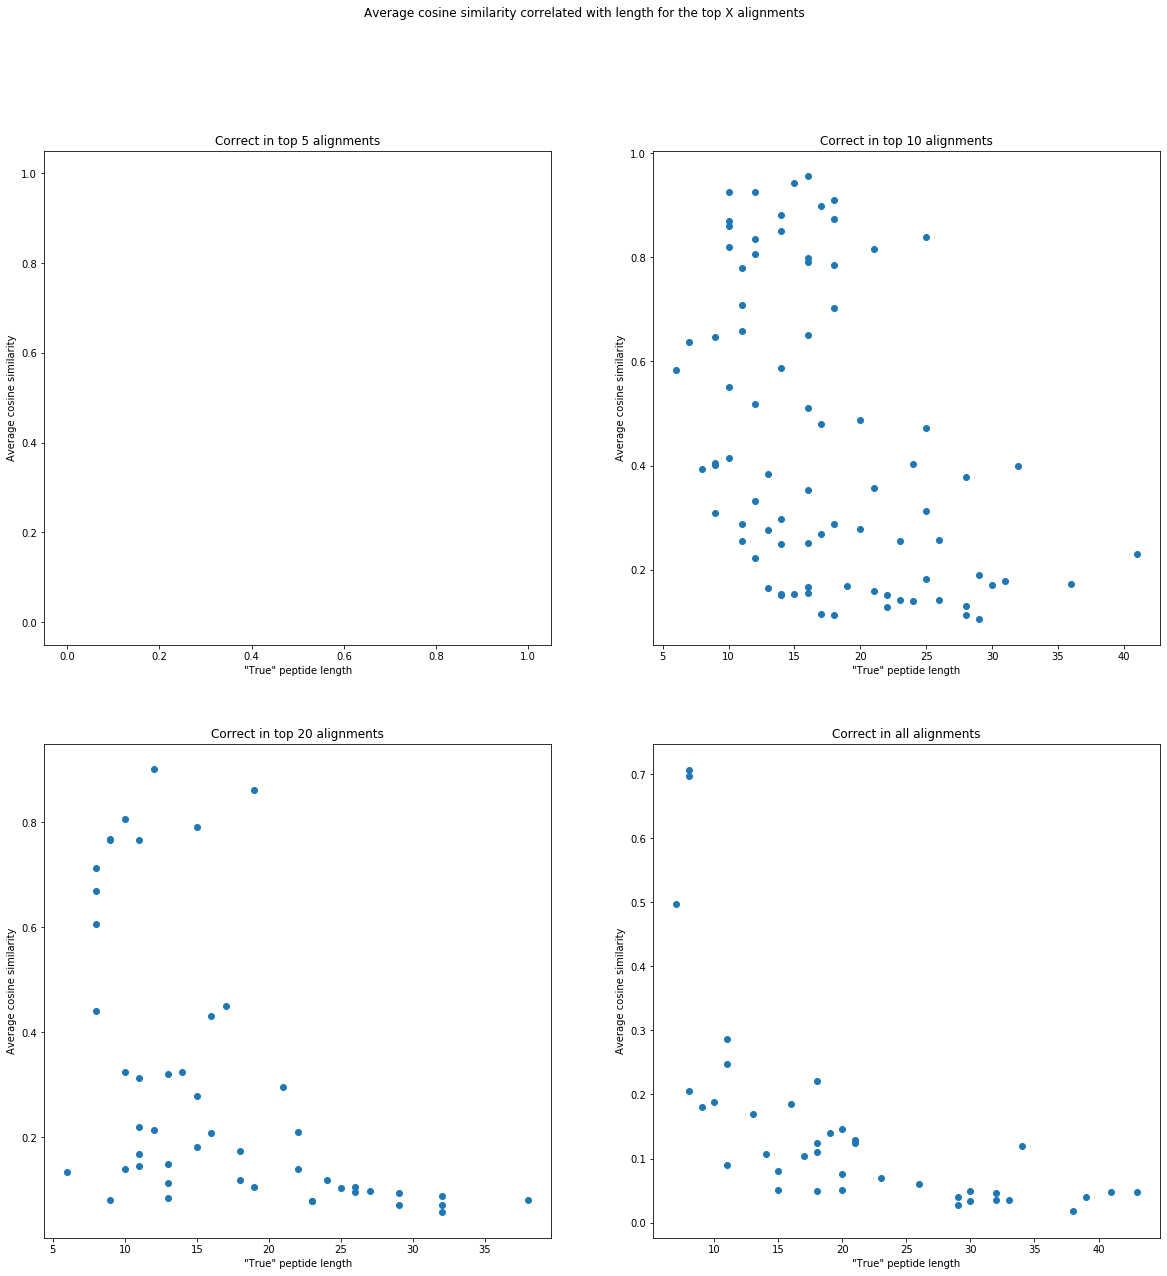

In [23]:
css = [cs_len_5, cs_len_10, cs_len_20, cs_len_all]
titles = ['Correct in top 5 alignments', 'Correct in top 10 alignments', 'Correct in top 20 alignments', 'Correct in all alignments']

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Average cosine similarity correlated with length for the top X alignments')

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter([x[1] for x in css[i]], [x[0] for x in css[i]])
    ax.set_xlabel('"True" peptide length')
    ax.set_ylabel('Average cosine similarity')
    ax.set_title(titles[i])
    


#### first alignment round

In [20]:
first_as = [x for x in nonhybrid_typed_fall_off['first_alignment_round']]

In [21]:
def most_aa_overlap(truth, trying):
    overlap = 0
    
    if truth == trying:
        return len(truth)
    
    i = 0
    while i < len(truth) and i < len(trying) and trying[i] == truth[i]:
        i += 1
        overlap += 1
        
    i = -1
    while i > -1 * min(len(trying), len(truth)) and truth[i] == trying[i]:
        i -= 1
        overlap += 1
        
    return overlap - max(0, len(trying) - len(truth))

for _id, fa in first_as:
    
    t_seq = fa['truth_sequence']
    
    most_overlap = defaultdict(list)
    for non_hyb, hyb in fa['meta_data']['alignments']:
        most_overlap[most_aa_overlap(t_seq, non_hyb)].append((non_hyb, hyb))
        
    most_aas = max(list(most_overlap.keys()))
    closest_matches = most_overlap[most_aas]
    
    
    print(f'({_id}) Closest alignments to sequence {t_seq} at overlap {most_aas}')
    print('=================================================================')
    [print(f'{non_hyb} \t {hyb}') for non_hyb, hyb in closest_matches]
    print()
    

(NOD2_E3.8705.8734.3.pkl) Closest alignments to sequence DMANQVKAPLVLKD at overlap 4
DINELKPGNLLKD 	 None
KLLKEGEEPTVLKD 	 KLLKEGEEPTV-LKD
DGVTVAKSIDLKD 	 None
KLGGSAVLKD 	 KLGGSAV-LKD
PNGTDVYKGVLKD 	 None

